<a href="https://colab.research.google.com/github/alec-carawan/Intro-to-Machine-Learning/blob/main/HW4_Q1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn import datasets
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import seaborn as sns

In [2]:
cancerURL    =  'https://raw.githubusercontent.com/alec-carawan/datasets/main/cancer.csv'
housingURL   =  'https://raw.githubusercontent.com/alec-carawan/datasets/main/Housing.csv'

cancerSet    =   pd.read_csv(cancerURL)
housingSet   =   pd.read_csv(housingURL)

In [3]:
#id is a useless variable when diagnosing cancer, it should be removed from the dataset
cancerSet.pop('id')

#cancer set also has an extra column of NaN values, this should be removed
cancerSet = cancerSet.drop(cancerSet.columns[-1], axis = 1)

In [4]:
#standardize string data to numeric data
#cancerSet['diagnosis'] = cancerSet['diagnosis'].map({'M': 1, 'B': 0})

# List of variables to map

varlist =  ['mainroad', 'guestroom', 'basement', 'hotwaterheating', 'airconditioning', 'prefarea']

# Defining the map function
def binary_map(x):
    return x.map({'yes': 1, 'no': 0})

# Applying the function to the housing list
housingSet[varlist] = housingSet[varlist].apply(binary_map)

#map furnishing status
housingSet['furnishingstatus'] = housingSet['furnishingstatus'].map({'furnished': 2, 'semi-furnished': 1, 'unfurnished': 0})

In [5]:
#STANDARDIZE DATA

from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
#DIAGNOSIS REMOVED
num_vars = ['radius_mean','texture_mean','perimeter_mean','area_mean',
            'smoothness_mean','compactness_mean','concavity_mean','concave points_mean',
            'symmetry_mean','fractal_dimension_mean','radius_se','texture_se','perimeter_se',
            'area_se','smoothness_se','compactness_se','concavity_se','concave points_se',
            'symmetry_se','fractal_dimension_se','radius_worst','texture_worst',
            'perimeter_worst','area_worst','smoothness_worst','compactness_worst',
            'concavity_worst','concave points_worst','symmetry_worst','fractal_dimension_worst']

cancerSet[num_vars] = scaler.fit_transform(cancerSet[num_vars])

num_vars = ['price','area','bedrooms','bathrooms','stories','mainroad','guestroom','basement','hotwaterheating','airconditioning','parking','prefarea','furnishingstatus']
#using num_vars keeps data types as data frames, instead of np arrays which do not allow pop and head functions

housingSet[num_vars] = scaler.fit_transform(housingSet[num_vars])

In [6]:
from sklearn.preprocessing import StandardScaler
features = ['radius_mean','texture_mean','perimeter_mean','area_mean',
            'smoothness_mean','compactness_mean','concavity_mean','concave points_mean',
            'symmetry_mean','fractal_dimension_mean','radius_se','texture_se',
            'perimeter_se','area_se','smoothness_se','compactness_se','concavity_se',
            'concave points_se','symmetry_se','fractal_dimension_se','radius_worst',
            'texture_worst','perimeter_worst','area_worst','smoothness_worst',
            'compactness_worst','concavity_worst','concave points_worst','symmetry_worst',
            'fractal_dimension_worst']
# Separating out the features
x = cancerSet.loc[:, features].values
# Separating out the target
y = cancerSet.loc[:,['diagnosis']].values
# Standardizing the features
x = StandardScaler().fit_transform(x)

In [7]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
principalComponents = pca.fit_transform(x)
principalDf = pd.DataFrame(data = principalComponents
             , columns = ['principal component 1', 'principal component 2'])
principalDf.head()

,principal component 1,principal component 2
0,9.192837,1.948583
1,2.387802,-3.768172
2,5.733896,-1.075174
3,7.122953,10.275589
4,3.935302,-1.948072


In [8]:
cancerSetPCA = pd.concat([principalDf, cancerSet[['diagnosis']]], axis = 1)

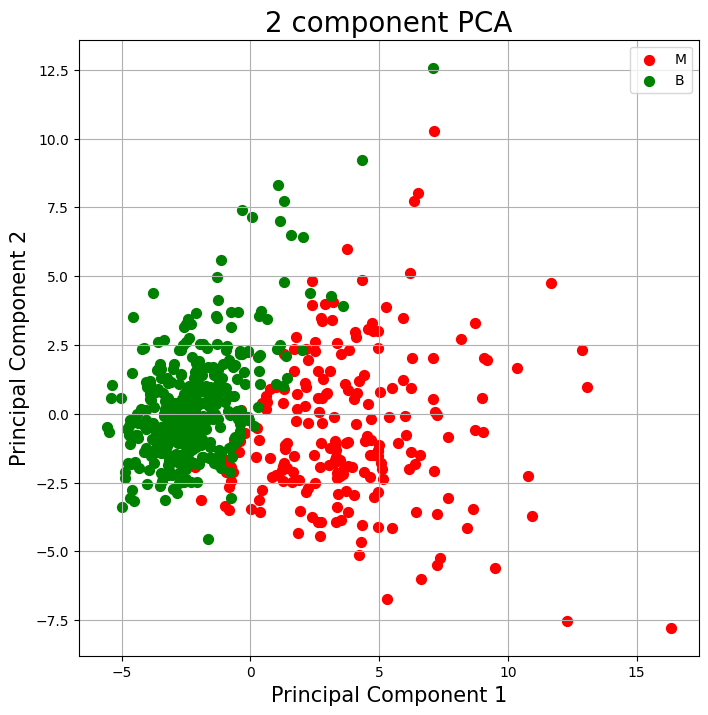

In [9]:
fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1)
ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)
ax.set_title('2 component PCA', fontsize = 20)
targets = ['M',  'B']
colors = ['r', 'g']
for target, color in zip(targets,colors):
    indicesToKeep = cancerSetPCA['diagnosis'] == target
    ax.scatter(cancerSetPCA.loc[indicesToKeep, 'principal component 1']
               , cancerSetPCA.loc[indicesToKeep, 'principal component 2']
               , c = color
               , s = 50)
ax.legend(targets)
ax.grid()

Split into training and verification data

In [10]:
from sklearn.model_selection import train_test_split

# We specify this so that the train and test data set always have the same rows, respectively
np.random.seed(0)

cancerTrain, cancerTest = train_test_split(cancerSetPCA, train_size = 0.8, test_size = 0.2, random_state = 100)

In [11]:
features = ['principal component 1', 'principal component 2']
y = cancerTrain.loc[:, 'diagnosis'].values
X = cancerTrain.loc[:, features].values

In [12]:
# "Linear Support vector classifier"
from sklearn.svm import SVC
model = SVC(kernel='linear', C=1E5)
#Chose C=1E5 because larger Cs gave me a very small decision boundry
#Larger values of C also took MUCH longer to compile
model.fit(X, y)

SVC(C=100000.0, kernel='linear')

In [13]:
#Map malig / benign to 1-0 for graphing
y[y == 'B'] = 0
y[y == 'M'] = 1

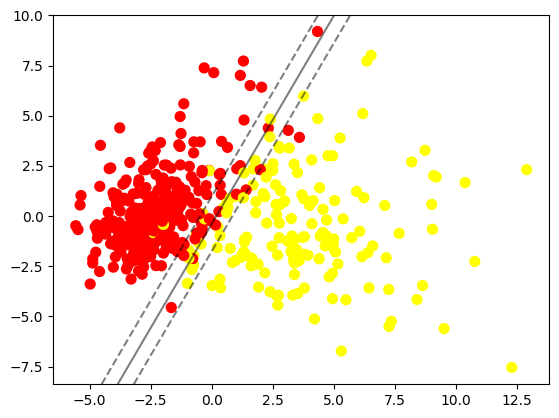

In [14]:
#To better visualize what's happening here, let's create a quick convenience function that will plot SVM decision boundaries for us:
def plot_svc_decision_function(model, ax=None, plot_support=True):
    """Plot the decision function for a 2D SVC"""
    if ax is None:
        ax = plt.gca()
    xlim = ax.get_xlim()
    ylim = ax.get_ylim()

    # create grid to evaluate model
    x = np.linspace(xlim[0], xlim[1], 30)
    y = np.linspace(ylim[0], ylim[1], 30)
    Y, X = np.meshgrid(y, x)
    xy = np.vstack([X.ravel(), Y.ravel()]).T
    P = model.decision_function(xy).reshape(X.shape)

    # plot decision boundary and margins
    ax.contour(X, Y, P, colors='k',
               levels=[-1, 0, 1], alpha=0.5,
               linestyles=['--', '-', '--'])

    # plot support vectors
    if plot_support:
        ax.scatter(model.support_vectors_[:, 0],
                   model.support_vectors_[:, 1],
                   s=300, linewidth=1, facecolors='none');
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)
plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='autumn')
plot_svc_decision_function(model);

<ipython-input-15-bdafbf6e61c8>:13: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  y[y == 'B'] = 0
<ipython-input-15-bdafbf6e61c8>:14: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  y[y == 'M'] = 1
<ipython-input-15-bdafbf6e61c8>:13: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  y[y == 'B'] = 0
<ipython-input-15-bdafbf6e61c8>:14: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  y[y == 'M'] = 1


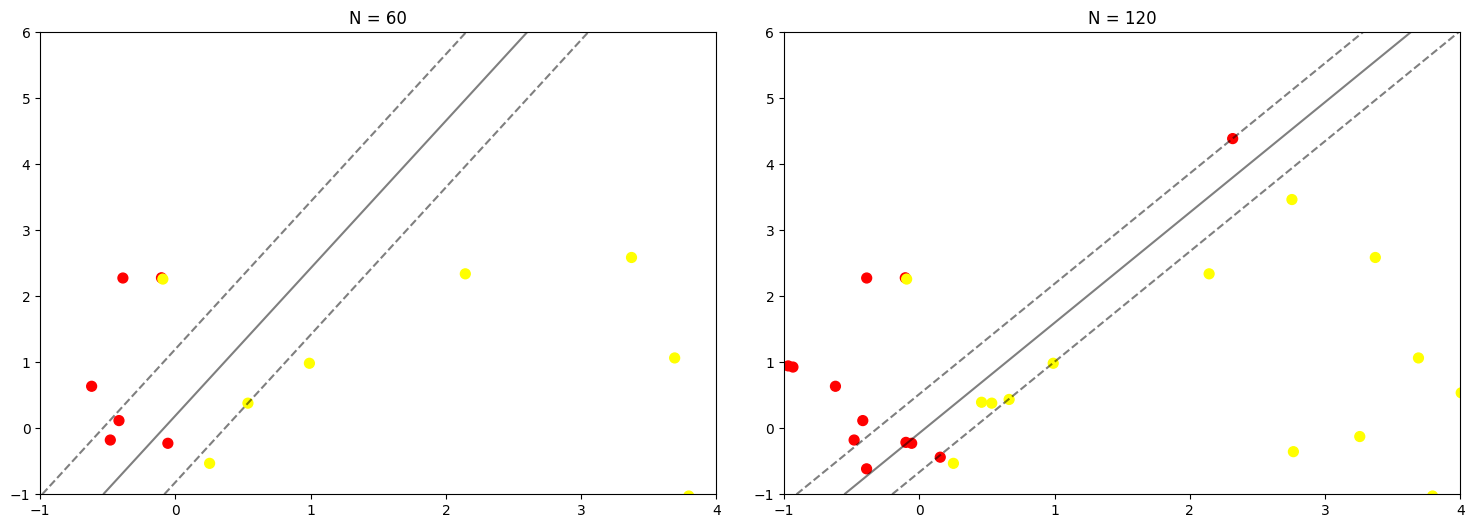

In [15]:
def plot_cancer_svm(N=10, ax=None):
    y = cancerTrain.loc[:, 'diagnosis'].values
    X = cancerTrain.loc[:, features].values

    X = X[:N]
    y = y[:N]
    y=y.astype('int')

    model = SVC(kernel='linear', C=1E5)
    model.fit(X, y)

    #Map malig / benign to 1-0 for graphing
    y[y == 'B'] = 0
    y[y == 'M'] = 1

    ax = ax or plt.gca()
    ax.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='autumn')
    ax.set_xlim(-1, 4)
    ax.set_ylim(-1, 6)
    plot_svc_decision_function(model, ax)

fig, ax = plt.subplots(1, 2, figsize=(16, 6))
fig.subplots_adjust(left=0.0625, right=0.95, wspace=0.1)
for axi, N in zip(ax, [60, 120]):
    plot_cancer_svm(N, axi)
    axi.set_title('N = {0}'.format(N))

interactive(children=(Dropdown(description='N', options=(10, 25, 50, 100, 150, 200, 300), value=10), Output())…

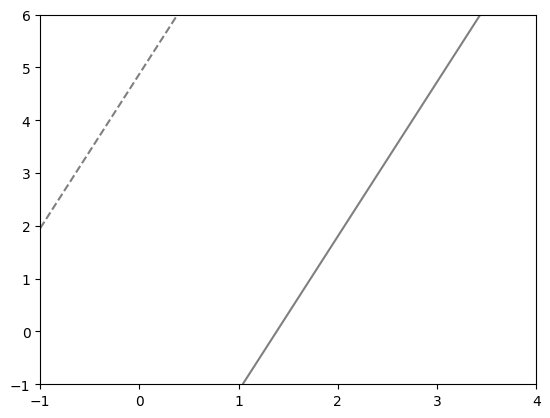

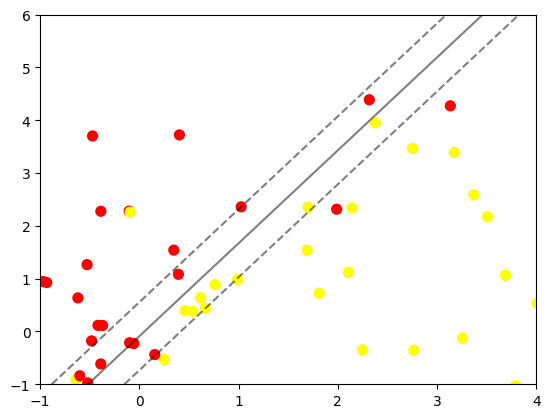

In [16]:
from ipywidgets import interact, fixed
interact(plot_cancer_svm, N=[10,25, 50, 100, 150, 200, 300], ax=fixed(None));

Optimum number K is N = 200

In [17]:
r = np.exp(-(X ** 2).sum(1))

interactive(children=(Dropdown(description='elev', options=(-180, 180), value=-180), IntSlider(value=30, descr…

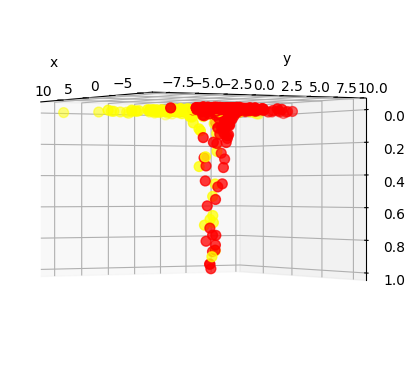

In [18]:
from mpl_toolkits import mplot3d

def plot_3D(elev=30, azim=30, X=X, y=y):
    ax = plt.subplot(projection='3d')
    ax.scatter3D(X[:, 0], X[:, 1], r, c=y, s=50, cmap='autumn')
    ax.view_init(elev=elev, azim=azim)
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.set_zlabel('r')

interact(plot_3D, elev=[-180, 180], azip=(-180, 180),
         X=fixed(X), y=fixed(y));

This model does not seem to identify any non-linearities

In [19]:
clf = SVC(kernel='rbf', C=1E6) #rbf: radial basis function
#kernel{‘linear’, ‘poly’, ‘rbf’, ‘sigmoid’, ‘precomputed’}, default=’rbf’
#Specifies the kernel type to be used in the algorithm.
#It must be one of ‘linear’, ‘poly’, ‘rbf’, ‘sigmoid’, ‘precomputed’ or a callable. If none is given, ‘rbf’ will be used.
y=y.astype('int')
clf.fit(X, y)

SVC(C=1000000.0)

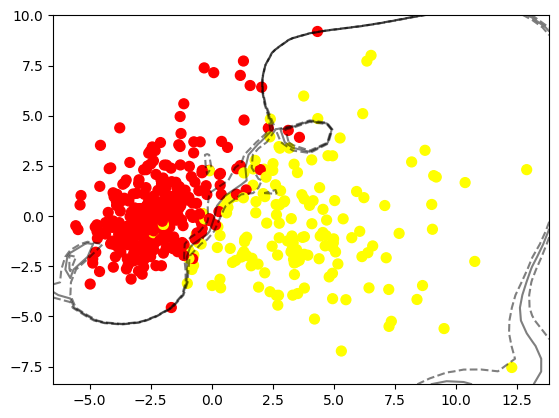

In [20]:
plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='autumn')
plot_svc_decision_function(clf)
plt.scatter(clf.support_vectors_[:, 0], clf.support_vectors_[:, 1],
            s=300, lw=1, facecolors='none');

This model does not seem to identify any non-linearities